# Large-scale structure simulations

In this tutorial, we will explore N-body simulations of the large-scale structure (LSS) of the Universe. These simulations involve a collection of massive particles with finite resolution that interact gravitationally. They represent the evolved distribution of matter, visualized as snapshots at various redshifts.

In [1]:
import numpy as np
from glob import glob
#to install Pylians: https://pylians3.readthedocs.io/en/master/
import MAS_library as MASL
import Pk_library as PKL
import smoothing_library as SL
from Corrfunc.theory import xi#check https://corrfunc.readthedocs.io/en/master/api/Corrfunc.theory.html#Corrfunc.theory.xi

In [2]:
import h5py 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [7]:
plt.style.use('/home/jarmijo/plots/pltstyle.mplstyle')#copy from github, use your own path.

## Quijote simulations

We will focus on simulation data of the Quijote simulations. These have $N_p = 10^9$ (1 billion) particles over a size of $L_{\rm box} = 1024\ {\rm Mpc} h^{-1}$. These are used to study the summary statistics of a given cosmological model (See next tutorial). Here we will learn how to visualize them and use to calculate their power spectrum and correlation function. 

## Show matter field: $\delta_{\rm m}\ $
These simulations have both DM and neutrino as particles. We will treat both equally for simplicity.

Use the Pylians routines to handle particle data. Please try to run this notebook in a node with enough memory (in idark; a few cores should do the trick) as reading particles can be memory expensive.

In [5]:
snapshot = '/lustre/work/Globus-lt/CD3/Quijote-fR/Snapshots/102/snapdir_004/snap_004'  #snapshot name
Lbox = 1024
Np = 1024**3
nthreads=16
grid     = 500                     #grid size
ptypes   = [1,2]                   #CDM + neutrinos
MAS      = 'CIC'                   #Cloud-in-Cell
do_RSD   = False                   #dont do redshif-space distortions
axis     = 0                       #axis along which place RSD; not used here
verbose  = True   #whether print information on the progress

# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0




Computing density field of particles [1, 2]
9.83881356e+19 should be equal to
9.83881356e+19
Time taken = 19.63 seconds


And we can plot the grid projecting some of the slices in a 2D plane. Let's use 3 projections using xyz. We only need to select the slice thickness $N_{\rm s}$ and sum over the projected dimension.

In [21]:
#select slice of matter field. Each sclice will have a depth of Lbox / grid
Ns = 2
rho_2D_xy = np.sum(delta[:,:,:Ns] + 1,axis=2) #We need to project the simulation in 2D
rho_2D_yz = np.sum(delta[:Ns,:,:] + 1,axis=0) 
rho_2D_zx = np.sum(delta[:,:Ns,:] + 1,axis=1) 
min_overdensity = 0.3      #minimum overdensity to plot
max_overdensity = 200.0    #maximum overdensity to plot
rho_2D_xy.shape,rho_2D_yz.shape,rho_2D_zx.shape

((500, 500), (500, 500), (500, 500))

Each projection has grid units. We can plot in physical units Mpc/$h$ by using the $\texttt{extent}$ key in matplotlib. Let's also zoom to check the details of the LSS.

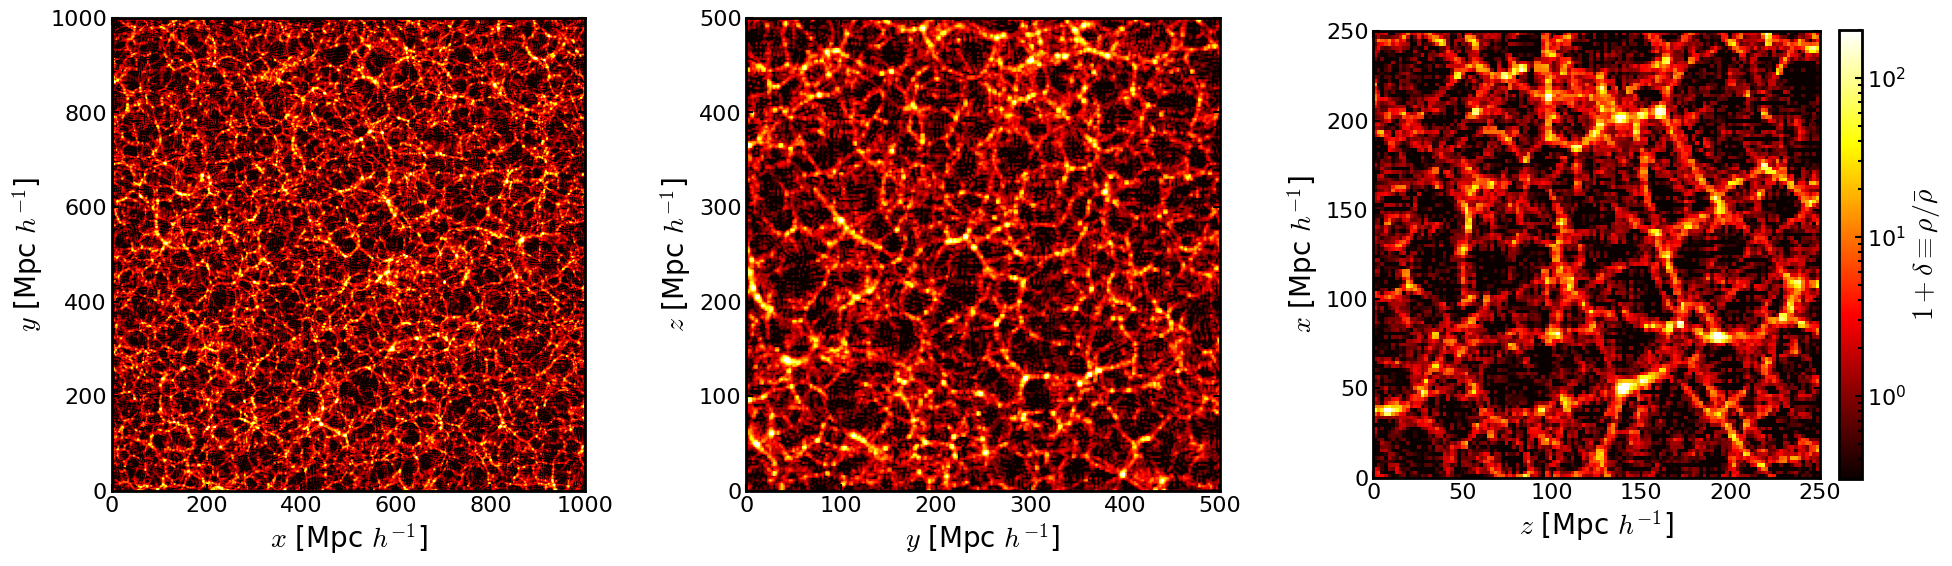

In [35]:
f,ax = plt.subplots(1,3,figsize=(20,6))
cm1 = ax[0].imshow(rho_2D_xy,origin='lower',cmap='hot',norm = LogNorm(vmin=min_overdensity,vmax=max_overdensity),extent=[0,1024,0,1024])
ax[1].imshow(rho_2D_yz,origin='lower',cmap='hot',norm = LogNorm(vmin=min_overdensity,vmax=max_overdensity),extent=[0,1024,0,1024])
ax[2].imshow(rho_2D_zx.T,origin='lower',cmap='hot',norm = LogNorm(vmin=min_overdensity,vmax=max_overdensity),extent=[0,1024,0,1024])
clb1 = plt.colorbar(cm1,ax=ax[2],fraction=0.046, pad=0.04)
clb1.set_label(r'$1+\delta \equiv \rho/\bar{\rho}$')
ax[0].set_ylim(0,1000)
ax[0].set_xlim(0,1000)
ax[1].set_ylim(0,500)
ax[1].set_xlim(0,500)
ax[2].set_ylim(0,250)
ax[2].set_xlim(0,250)
ax[0].set_xlabel(r'$x$ [Mpc $h^{-1}$]')
ax[0].set_ylabel(r'$y$ [Mpc $h^{-1}$]')
ax[1].set_xlabel(r'$y$ [Mpc $h^{-1}$]')
ax[1].set_ylabel(r'$z$ [Mpc $h^{-1}$]')
ax[2].set_xlabel(r'$z$ [Mpc $h^{-1}$]')
ax[2].set_ylabel(r'$x$ [Mpc $h^{-1}$]')
plt.tight_layout()

plt.show()

Simulations have a lot of detail. Generaly we focus on the white spots located in the overdensities of the field. These are haloes and can be identified with a halo finder. From a halo sample, we can calculate a correlation function, which summarizes the cosmological information of the simulation in 1D (as function of the scale). Alternatively, we can directly compute the power spectrum over $\delta_{\rm m}$.

## Power spectrum and correlation function.
https://ned.ipac.caltech.edu/level5/Glossary/Essay_powerspm.html

For a given simulation box size overdensities the field $\delta$ can be decomposed in in waves with different scale dependent amplitude $\delta_k$ with $k$ being the different Fourier modes (wave numbers). The sum of all amplitudes (statistical average) over a volume $V$ can be written as:
$$\sum \left< \delta(k) \delta^*(k) \right> \equiv \frac{1}{V}\sum \delta_k^2   = \frac{1}{2\pi^2}\int P(k)k^2dk,$$ where $P(k)$ is the power spectrum. The power spectrum is easy to visualize: A completely flat power spectrum corresponds to white noise (i.e. equal power at all frequencies), while a power spectrum that is sharply peaked at some particular value of k has a characteristic length scale. A single plane wave has a power spectrum consisting of a single spike. 

In [42]:
# compute power spectrum
Pk = PKL.Pk(delta, Lbox, axis, MAS, nthreads, verbose,)

# Pk is a python class containing the 1D, 2D and 3D power spectra. For the 3D P(k) that can be retrieved as:
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole
Pk2     = Pk.Pk[:,1] #quadrupole
Pk4     = Pk.Pk[:,2] #hexadecapole
Pkphase = Pk.Pkphase #power spectrum of the phases
Nmodes  = Pk.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 5.20
Time taken = 8.28 seconds


Under a Fourier transform, the same statistic can be computed in configuration space, This is the two-point correlation function.

In [43]:
CF     = PKL.Xi(delta, Lbox, MAS, axis, nthreads)

# get the attributes
r      = CF.r3D      #radii in Mpc/h
xi0    = CF.xi[:,0]  #correlation function (monopole)
xi2    = CF.xi[:,1]  #correlation function (quadrupole)
xi4    = CF.xi[:,2]  #correlation function (hexadecapole)
Nmodes = CF.Nmodes3D #number of modes


Computing correlation function of the field...
Time to complete loop = 0.91
Time taken = 8.57 seconds


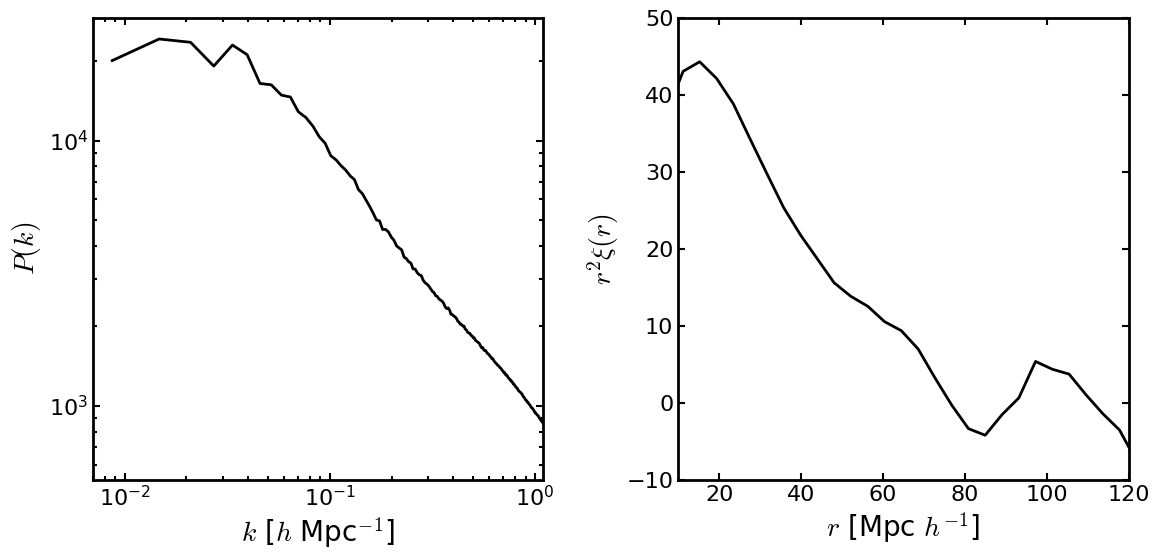

In [62]:
f,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(k,Pk0,'k-',lw=2)
ax[1].plot(r[::2],r[::2]**2*xi0[::2],'k-',lw=2)
ax[0].set_ylabel(r'$P(k)$')
ax[0].set_xlabel(r'$k$ [$h$ Mpc$^{-1}$]')
ax[1].set_ylabel(r'$r^2\xi(r)$')
ax[1].set_xlabel(r'$r$ [Mpc $h^{-1}$]')
ax[0].set_xlim(0.007,1.1)
ax[1].set_ylim(-10,50)
ax[1].set_xlim(10,120)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
plt.tight_layout()
plt.show()

However, we don't observe the matter field, but a biased (tracers) version. So we need to find the haloes $\delta_{\rm m}$

# Halo catalogue and two-point correlation function.

To find haloes we need an external code as this represent a difficult task. These are normally based on finding gravitationally bound particles looking at positions and velocities. For these simulations the code used is $\texttt{Rockstar}$. We can give a look to a $\texttt{Rockstar}$ catalogue.

## ================= Rockstar file columns ===================
    -ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Type SM Gas BH_Mass PID
    a = 0.250678
    Om = 0.354488; Ol = 0.645512; h = 0.661886
    #FOF linking length: 0.280000
    #Unbound Threshold: 0.500000; FOF Refinement Threshold: 0.700000
    #Particle mass: 7.28275e+11 Msun/h
    #Box size: 1000.000000 Mpc/h
    #Force resolution assumed: 0.05 Mpc/h
    #Units: Masses in Msun / h
    #Units: Positions in Mpc / h (comoving)
    #Units: Velocities in km / s (physical, peculiar)
    #Units: Halo Distances, Lengths, and Radii in kpc / h (comoving)
    #Units: Angular Momenta in (Msun/h) * (Mpc/h) * km/s (physical)
    #Units: Spins are dimensionless
    #Np is an internal debugging quantity.
    #Rockstar-Galaxies Version: 0.99.9-RC3-newA

We can read one of these examples and show how it represents a biased traced version of the previous simulation.

## Read haloes

In [102]:
haloes_dir = '/lustre/work/Globus-lt/CD3/Quijote-fR/Halos/Rockstar/102/'
haloes_list = glob(haloes_dir+'out_4_pid.list')#This should find all name files with same pattern (sometimes is more thah one).

In [69]:
haloes_list

['/lustre/work/Globus-lt/CD3/Quijote-fR/Halos/Rockstar/102/out_4_pid.list']

In [70]:
haloes = []
for l in haloes_list:
    haloes.append(np.loadtxt(l,usecols=(8,9,10,21)))
haloes = np.concatenate(haloes)

In [71]:
len(haloes)# This is the amount of haloes (compared to 1 billion particle this is much easier to handle).

141565

We can make a mass cut to focus in the more massive haloes. As homework, give a look to the halo mass function and select the mass range where the simulation looks "complete".

In [72]:
Mcut = 1e12 #
haloes_sel = haloes[haloes[:,-1] > Mcut]

In [90]:
haloes_plot = haloes_sel[(haloes_sel[:,2] > 0)&(haloes_sel[:,2] < Nslice*(Lbox/grid))]#Similar to before we plot only the projected grid

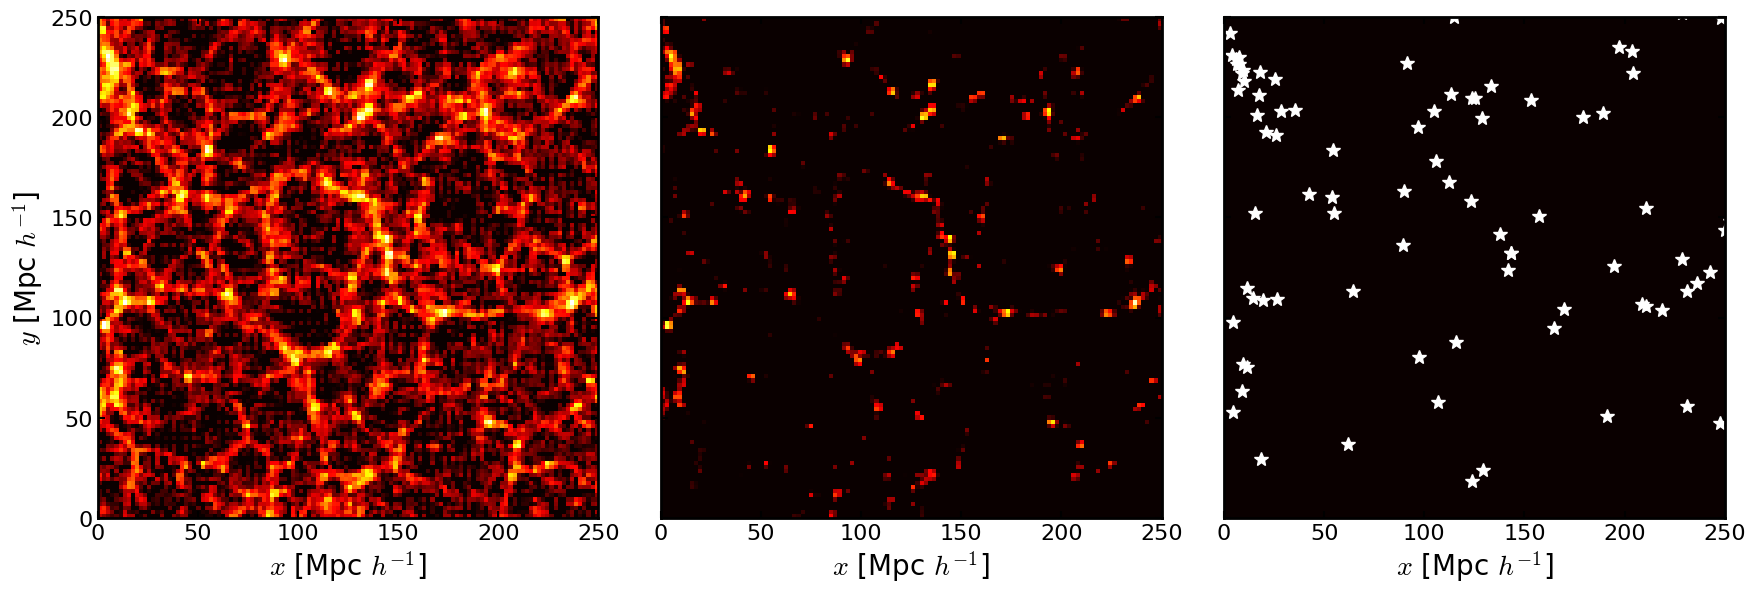

In [100]:
f,ax = plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
cm1 = ax[0].imshow(rho_2D_xy.T,origin='lower',cmap='hot',norm = LogNorm(vmin=min_overdensity,vmax=max_overdensity),extent=[0,1024,0,1024])
ax[1].imshow(rho_2D_xy.T,origin='lower',cmap='hot',norm = LogNorm(vmin=8,vmax=500),extent=[0,1024,0,1024])#bias the color threhshold
ax[2].imshow(rho_2D_xy.T,origin='lower',cmap='hot',norm = LogNorm(vmin=500,vmax=500),extent=[0,1024,0,1024])#black bg
ax[2].plot(haloes_plot[:,0]+2,haloes_plot[:,1]+5,'w*',ms=10)
ax[0].set_ylim(0,250)
ax[0].set_xlim(0,250)
ax[0].set_xlabel(r'$x$ [Mpc $h^{-1}$]')
ax[0].set_ylabel(r'$y$ [Mpc $h^{-1}$]')
ax[1].set_xlabel(r'$x$ [Mpc $h^{-1}$]')
ax[2].set_xlabel(r'$x$ [Mpc $h^{-1}$]')
#plt.savefig('/home/jarmijo/Quijote_fR/imgs/delta_haloes_Correlation_function',bbox_inches='tight')
plt.tight_layout()
plt.show()

The missing one are most likely projection effects, or the Halo finder not being perfect, but we see how haloes are a biased traces of the matter field. They follow the same structures as $\delta$ and are more 'observable' as we think that the galaxies we observe are more likely to live in massive haloes.

Biasing the field has also an impact on the calculated stastistic.

## Run correlation function

For biased tracers the correlation function $\xi(r)$ represents the excess of galaxy (halo) pairs found at a give separation (scale):
$$ n_{\rm pair} =  \bar{n} (1+\xi(r))\delta V_1 \delta V_2,$$ where $\delta V_1$ and $\delta V_2$ are volumes separated by distance $r$. 

It can be shown that the 2-pt correlation function (and the power spectrum) of haloes $\xi_{\rm hh}$ is a biased quantity of $\xi_{\rm mm}$, the one for matter. This is the linear bias: $$\xi_{\rm hh} = \xi_{\rm mm}b^2 $$. We can estimate by estimating $\xi_{\rm hh}$, which is calculated relating the number of halo pairs in comparison to random distribution (Landy-Szalay estimator):
$$\xi = \frac{DD}{RR} - 1,$$,
where DD is the number of galaxy pairs at different separation bins and RR is the one for randoms. For a box with periodic boundary conditions RR only depends on $\bar{n}$ the mean number density of galaxies and can be estimated analitially, which make the ccomputational estimation faster.

In [106]:
#Nb = 25
#rbins = np.logspace(np.log10(0.5),np.log10(120),Nb+1)

rbins = r[1:100]#Let's calculate the first 99 bins

In [108]:
#use Corrfunc for tracers 2PCF
xi_haloes = xi(
    boxsize= 1024,
    nthreads=16,
    binfile=rbins,
    X = haloes_sel[:,0],
    Y = haloes_sel[:,1],
    Z = haloes_sel[:,2],
    output_ravg=True,
)

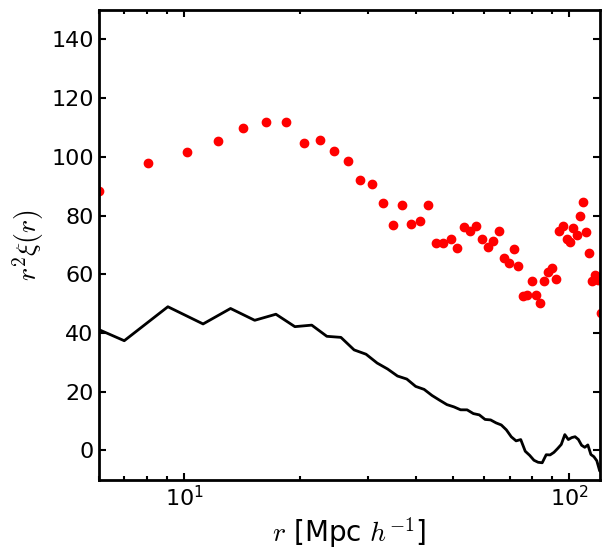

In [119]:
f,ax = plt.subplots(1,1,figsize=(6.5,6))
ax.plot(xi_haloes['ravg'],xi_haloes['ravg']**2*xi_haloes['xi'],'ro')
ax.plot(r,r**2*xi0,'k-',lw=2)
ax.set_ylabel(r'$r^2\xi(r)$')
ax.set_xlabel(r'$r$ [Mpc $h^{-1}$]')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(6,120)
ax.set_ylim(-10,150)
plt.tight_layout()
plt.show()

There's a linear scale where the (linear) bias it's roughly a constant ($\sim$ 15 - 50 Mpc $h^{-1}$)

In [129]:
r[2:18],xi_haloes['ravg'][:16]#bins are shifted, but for the sake of the example.

(array([ 6.9909291 ,  9.07332347, 11.19668451, 13.19405951, 15.24372639,
        17.30212381, 19.37886865, 21.43516029, 23.45737627, 25.5148597 ,
        27.60920806, 29.65113609, 31.68484851, 33.72803125, 35.77542994,
        37.82782333]),
 array([ 6.00333968,  8.0739973 , 10.17835647, 12.23035947, 14.25020912,
        16.30129016, 18.36945401, 20.43228445, 22.46893931, 24.51054568,
        26.58448419, 28.64864185, 30.68755808, 32.72333554, 34.77071194,
        36.81914517]))

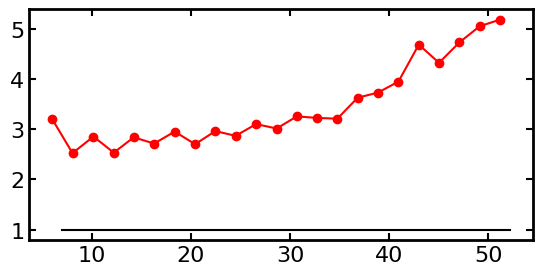

In [130]:
f,ax = plt.subplots(1,1,figsize=(6.5,3))
ax.plot(r[2:25],np.ones_like(r[2:25]),'k-')
ax.plot(xi_haloes['ravg'][:23],xi_haloes['xi'][:23]/ xi0[2:25],'ro-')
plt.show()


In [132]:
b_2 = np.mean(xi_haloes['xi'][:16]/ xi0[2:18])
print('Linear bias is b = %.2lf'%np.sqrt(b_2))

Linear bias is b = 1.72


This value can also be estimated in observational data by measuring the redshift-space distortion version of $\xi$ (Kaiser factor).